In [195]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import glob
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as trns
import torch.nn as nn
from torchmetrics import JaccardIndex
from sklearn.model_selection import train_test_split
from PIL import ImageColor
import matplotlib.patches as mpatches
import torchvision

In [196]:
class CustomData(Dataset):
    def __init__(self, train=True):
        self.images = []
        self.masks = []
        folders = glob.glob("../data/*")
        for f in folders:
            files = glob.glob(f"{f}/*")
            self.images.append(glob.glob(f"{files[0]}/*")); self.masks.append(glob.glob(f"{files[1]}/*"))
        self.images= np.array(self.images).reshape(-1); self.masks = np.array(self.masks).reshape(-1)
        X_train, X_test, y_train, y_test = train_test_split(self.images, self.masks, test_size=0.2, shuffle=True)
        self.np_images = []
        self.np_masks = []
        trans = trns.Compose([trns.ToTensor(), trns.Resize((256,256))])
        if train:
            for li, lm in zip(X_train, y_train):
                self.np_images.append(trans(plt.imread(li)))
                self.np_masks.append(trans(plt.imread(lm))[:3, :, :])
        else:
            for li, lm in zip(X_test, y_test):
                self.np_images.append(trans(plt.imread(li)))
                self.np_masks.append(trans(plt.imread(lm))[:3, :, :])        
        
    def __getitem__(self, index) :
        return self.np_images[index], self.np_masks[index]
    def __len__(self):
        return len(self.np_images)

In [197]:
Train_data = CustomData()
Test_data = CustomData(False)

In [198]:
train_loader = DataLoader(Train_data, 1, True)
test_loader= DataLoader(Test_data, 1, shuffle=True)

In [199]:
x = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


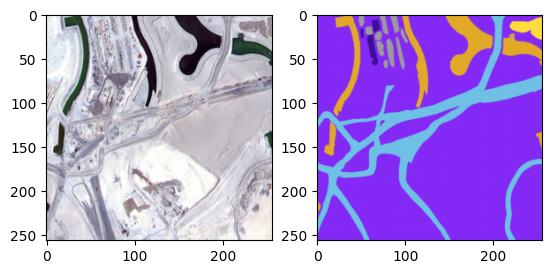

In [200]:

plt.subplot(1,2,1)
plt.imshow(x[0][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(x[1][0].permute(1,2,0))

In [201]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x
    

# Get UNet model
model = UNet()

In [202]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceloss, self).init()
    def forward(self,pred, target):
       smooth = 1e-6
       iflat = pred.contiguous().view(-1)
       torchlat = target.contiguous().view(-1)
       intersection = (iflat * torchlat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(torchlat * torchlat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [203]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

criterion = diceloss()

# # define learning rate scheduler (not used in this NB)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, T_0=1, T_mult=2, eta_min=5e-5,
# )




In [230]:
def Train_model(
        model,
        data_loader,
        criterion,
        optim,
        dice_fn,
        iou_fn
):
    losses= []
    dices = []
    ious = []
    model.train()
    for img , msk in data_loader:
        img, msk = img.to(DEVICE), msk.to(DEVICE)

        logits = model(img)
        loss = criterion(msk, logits)
        # props = nn.functional.softmax(logits, dim=1).cpu()
        dice = dice_fn(msk, logits)
        iou = iou_fn(msk, logits)
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.detach().cpu()); dices.append(dice.detach().cpu()); ious.append(iou.detach().cpu())
    print(f"Train Loss: {np.array(losses).mean() :.4f} | Train dice: {np.array(dices).mean():.4f} | Train iou: {np.array(ious).mean():.4f}")
    return np.array(losses).mean(), np.array(dices).mean(), np.array(ious).mean()

def Test_model(
        model,
        data_loader,
        criterion,
        dice_fn,
        iou_fn):
    losses, dices, ious = [], [], []
    model.eval()
    with torch.inference_mode():
        for img, msk in data_loader:
            img, msk = img.to(DEVICE), msk.to(DEVICE)
            logits = model(img)
            loss = criterion(logits, msk)
            # props= nn.functional.softmax(logits, dim=1).cpu()
            dice = dice_fn(msk, logits)
            iou = iou_fn(msk, logits)
            losses.append(loss.detach().cpu()); dices.append(dice.detach().cpu()); ious.append(iou.detach().cpu())
        print(f"Test Loss: {np.array(losses).mean() :.4f} | Test dice: {np.array(dices).mean():.4f} | Test iou: {np.array(ious).mean():.4f}")
        return np.array(losses).mean(), np.array(dices).mean(), np.array(ious).mean()


In [231]:
losses = []
cmS = []
tlosses=[]
tcmS = []

In [232]:
import torchmetrics

In [236]:
dice_fn = torchmetrics.Dice(num_classes= 6, average = 'macro').to(DEVICE)
iou_fn = torchmetrics.JaccardIndex(num_classes = 6, task= "multiclass", average = 'macro').to(DEVICE)

def accuracy_fn(preds, target):
    preds_flat = preds.flatten()
    target_flat = target.flatten()
    acc = torch.sum(preds_flat ==  target_flat)
    return acc/target_flat.shape[0]

In [234]:
model.to(DEVICE)
for i in range(10):
    print(f"{'#'*20} Epoch {i} {'#'*20}")
    print("Training....")
    l, cm = Train_model(model, train_loader, criterion, optimizer, dice_fn, iou_fn)
    losses.append(l); cmS.append(cm)
    print("Testing.......")
    lt, cmt = Test_model(model, test_loader, criterion, dice_fn, iou_fn)
    tlosses.append(lt); tcmS.append(cmt)   


#################### Epoch 0 ####################
Training....


ValueError: The `target` has to be an integer tensor.

In [209]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

In [210]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + 1e-6) / (union + 1e-6)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded

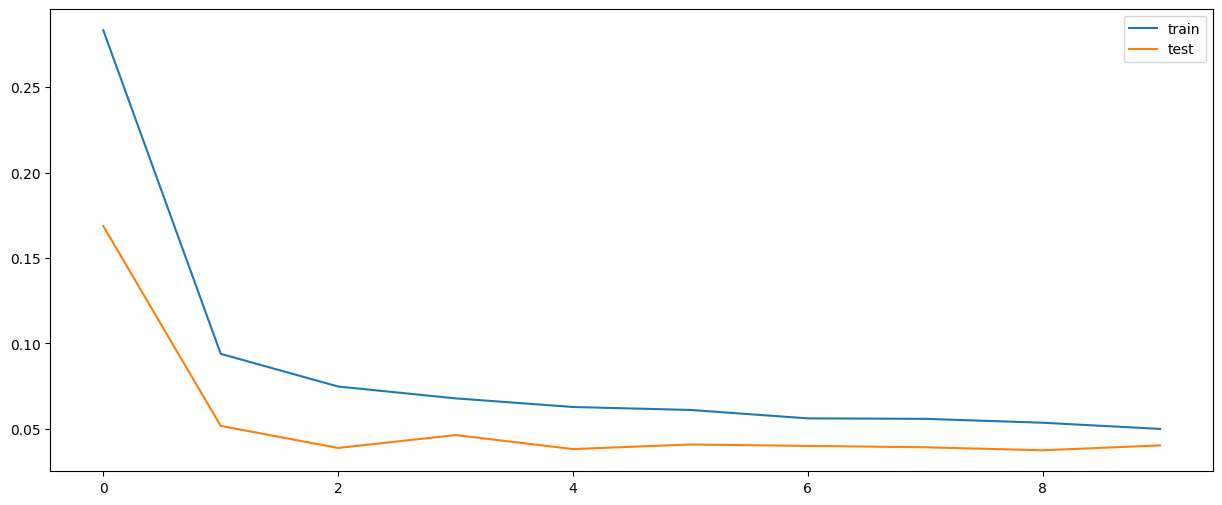

In [211]:
plt.figure(figsize=(15,6))
plt.plot(losses, label="train")
plt.plot(tlosses, label="test")
plt.legend()

In [212]:
d = iter(test_loader)

In [319]:
x = next(d)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


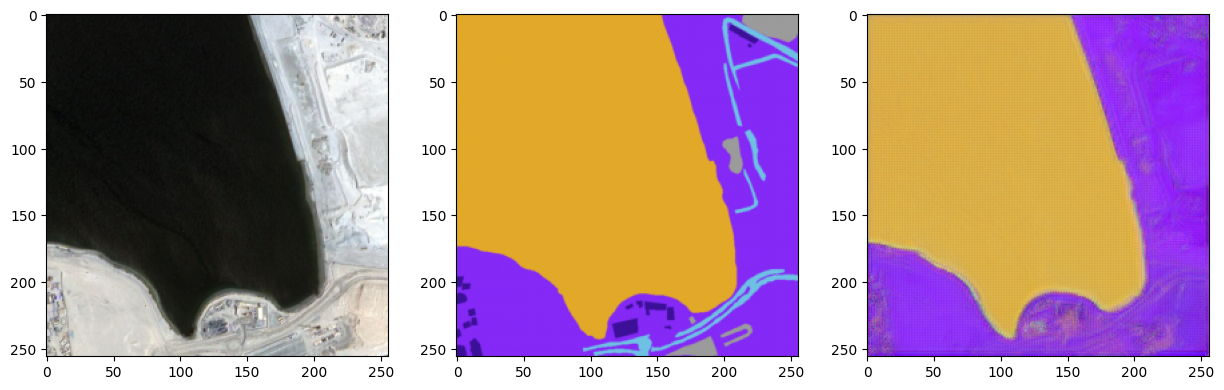

In [320]:
model.eval()
with torch.no_grad():
    pred = model(x[0][0].unsqueeze(0).to(DEVICE))

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(x[0].squeeze().permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(x[1].squeeze().permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(pred.squeeze().permute(1,2,0).cpu())

In [215]:
import umetrix

In [216]:
pred.shape

torch.Size([1, 3, 256, 256])

In [217]:
result = umetrix.calculate(
    x[0].squeeze().permute(1,2,0).numpy(),
    pred.squeeze().cpu().permute(1,2,0).numpy(),
    strict=True,
    iou_threshold=0.7
)

Metric,
n_true_labels,1
n_pred_labels,1
n_true_positives,1
n_false_positives,0
n_false_negatives,0
IoU,1.000
Jaccard,1.000
pixel_identity,0.000
localization_error,0.000

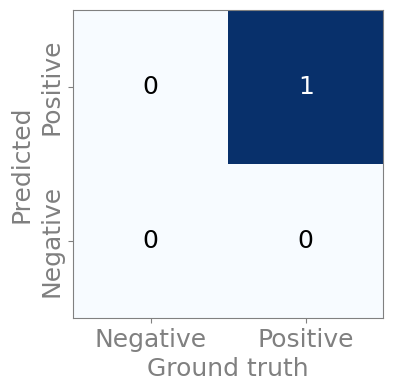

In [218]:
result.results

# segementation metrics 

#### Accuracy, Validation Accuracy, Loss, Validation Loss, IoU, Validation IoU

# hypred model 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


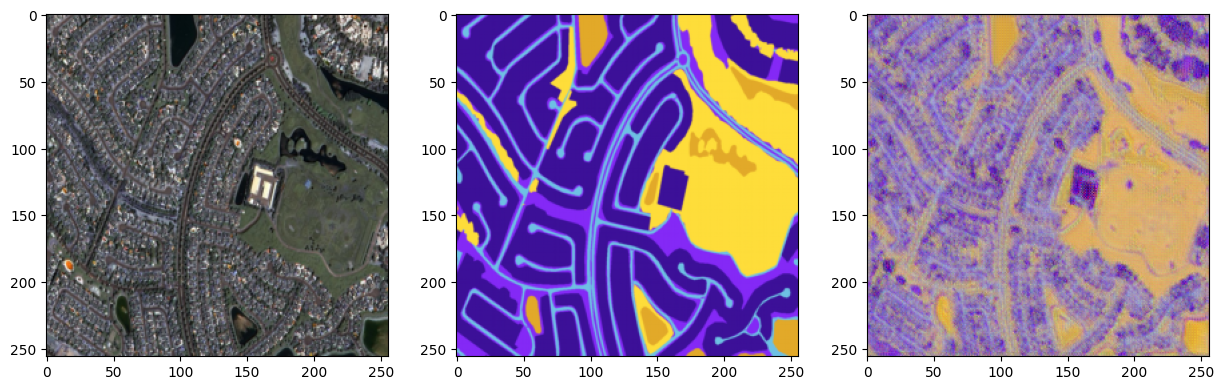

In [219]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(x[0].squeeze().permute(1,2,0))

plt.subplot(1,3,2)
plt.imshow(x[1].squeeze().permute(1,2,0))

plt.subplot(1,3,3)
plt.imshow(pred.cpu().squeeze().permute(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


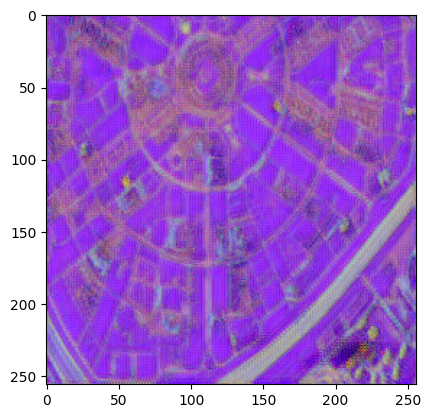

In [318]:
plt.imshow(pred.cpu().squeeze().permute(1,2,0))